In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import json
from decimal import Decimal
from folium import plugins


## Cleaning Data

In [2]:
data = pd.read_csv('food-inspections.csv')
data.head()


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2345323,ARMAND'S PIZZERIA,ARMAND'S PIZZERIA,2698587.0,Restaurant,Risk 1 (High),29 N WACKER DR,CHICAGO,IL,60606.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.882700,-87.636638,"{'longitude': '41.88270035458986', 'latitude':...",NaN,NaN,NaN,NaN,NaN
1,2345321,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,60613.0,...,Pass,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'...",NaN,NaN,NaN,NaN,NaN
2,2345325,TACO MAX MEXICAN GRILL,TACO MAX MEXICAN GRILL,2699082.0,Restaurant,Risk 1 (High),3402 W MONTROSE AVE,CHICAGO,IL,60618.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.961238,-87.713284,"{'longitude': '41.961237630038035', 'latitude'...",NaN,NaN,NaN,NaN,NaN
3,2345370,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,CHICAGO,IL,60622.0,...,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':...",NaN,NaN,NaN,NaN,NaN
4,2345376,GARIBAY POULTRY,GARIBAY POULTRY,1908500.0,CUSTOM POULTRY SLAUGHTER,Risk 2 (Medium),2100 S CALIFORNIA AVE,CHICAGO,IL,60608.0,...,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.853688,-87.695652,"{'longitude': '41.85368770723974', 'latitude':...",NaN,NaN,NaN,NaN,NaN


In [3]:
#First we create 3 new columns for time interval of the inspections
data['year']=data['Inspection Date'].apply(lambda x:x.split('-')[0]).astype(int)
data['month']=data['Inspection Date'].apply(lambda x:x.split('-')[1]).astype(int)
data['day']=data['Inspection Date'].apply(lambda x:x.split('-')[2].split('T')[0]).astype(int)

In [4]:
# Let's look in detail to the Zip code 
full_zip = data.groupby("Zip")["Facility Type"].describe()
full_zip.sort_values(by= "count", ascending=True).head(4)


,count,unique,top,freq
Zip,,,,
10014.0,0,0,NaN,NaN
60559.0,0,0,NaN,NaN
60438.0,1,1,Mobile Food Dispenser,1
60423.0,1,1,Shared Kitchen User (Long Term),1


We can see that some Zip codes have to few data's and restaurant we will thus need to do some webscrapping to get the missing information from those Zip codes to include them in our study

In [5]:
print("The number of Zip code in our dataset with less than 100 restaurant is",len(full_zip[full_zip["count"]<100]))

The number of Zip code in our dataset with less than 100 restaurant is 53


Let's consider only the dataset that contains non NA values for Longitude or Lagitude and we transform the Risk column into an int value column

In [6]:
loc= data[["Latitude","Longitude","AKA Name","Risk"]]
missing = loc[loc.isnull().any(axis = 1)]
data_removed = data.drop(missing.index)
data_removed = data_removed.reset_index()
data_removed["Risk"] = data_removed["Risk"].replace(to_replace =["All"],  
                            value =["Risk 1 (High)"]) 

In [7]:
# Let's look in detail to the Zip code in order to drop those 
restricted_zip = data_removed.groupby("Zip")["Facility Type"].describe()
restricted_zip.sort_values(by= "count", ascending=True).head(4)


,count,unique,top,freq
Zip,,,,
60559.0,0,0,NaN,NaN
60148.0,1,1,Shared Kitchen User (Long Term),1
60406.0,1,1,Shared Kitchen User (Long Term),1
60627.0,1,1,AFTER SCHOOL PROGRAM,1


In [8]:
print("The number of Zip code in our dataset with less than 100 restaurant is",len(restricted_zip[restricted_zip["count"]<100]))
print("The Zip codes are given by",restricted_zip[restricted_zip["count"]<100].index.values)

The number of Zip code in our dataset with less than 100 restaurant is 5
The Zip codes are given by [60148. 60406. 60501. 60559. 60627.]


We can see that after removing the NAN values from our data set, we have that the number of empty zip codes has diminished a lot, for the visualization part, for now we will not consider those Zip in our construction of the mapping of chicago since they do not containg restaurant type facilities in this data.

## Quick Risk overview

Looking at a quick study of the Risk we have the following Plots 

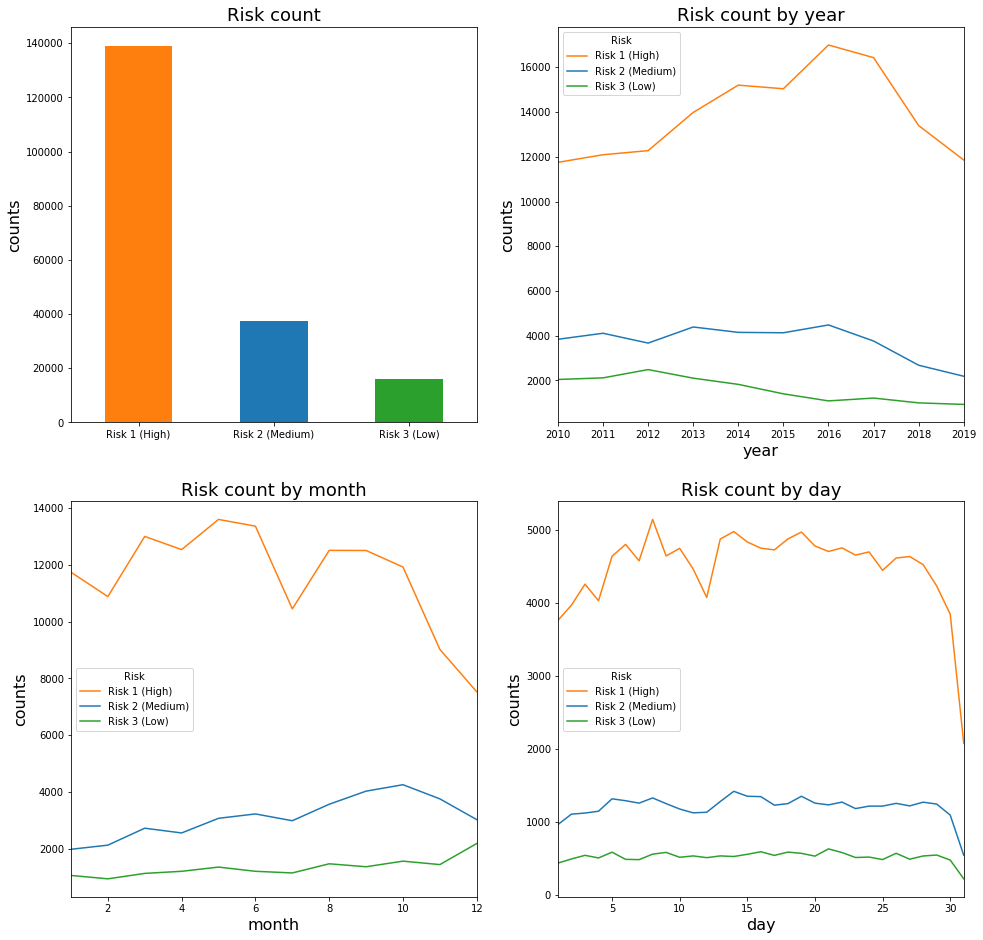

In [9]:
colors = ['C1','C0','C2']
fig,ax=plt.subplots(2,2,figsize=(16,16))
data_removed.Risk.value_counts().plot(kind = 'bar', color= colors, ax = ax[0,0]) 
ax[0,0].tick_params(axis='x',labelrotation=360)
ax[0,0].set_title("Risk count",size=18)
ax[0,0].set_ylabel('counts',size=16)

data_removed.groupby(['year','Risk'])['Inspection ID'].agg('count').unstack('Risk').plot(ax = ax[0,1], color = colors)
ax[0,1].set_title("Risk count by year",size=18)
ax[0,1].set_ylabel('counts',size=16)
ax[0,1].set_xlabel('year',size=16)


data_removed.groupby(['month','Risk'])['Inspection ID'].agg('count').unstack('Risk').plot(ax = ax[1,0], color = colors)
ax[1,0].set_title("Risk count by month",size=18)
ax[1,0].set_ylabel('counts',size=16)
ax[1,0].set_xlabel('month',size=16)

data_removed.groupby(['day','Risk'])['Inspection ID'].agg('count').unstack('Risk').plot(ax = ax[1,1], color = colors)
ax[1,1].set_title("Risk count by day",size=18)
ax[1,1].set_ylabel('counts',size=16)
ax[1,1].set_xlabel('day',size=16)

plt.show()

## Risk in function of the Zip codes

We now create a DataFrame containing all the data we want to plot in function of it Zip code hence we need to groupby zip and create features to our DataFrame

In [10]:
#We transform this with numerical values as follows
data_removed["Risk"] = data_removed["Risk"].replace(to_replace =["Risk 3 (Low)", "Risk 2 (Medium)", "Risk 1 (High)","All"],  
                            value =[1,2,3,3]) 
data_removed.Risk = data_removed.Risk.astype(float)
data_removed["Risk"].value_counts()

3.0    139031
2.0     37402
1.0     16192
Name: Risk, dtype: int64

In [18]:
#Groupby ZIPS
zip_data = data_removed.groupby("Zip")
# Count number of failed exams
failed = data_removed[data_removed['Results'] == 'Fail'].groupby('Zip')["Results"].count()
failed_per = ((failed/zip_data.Results.count())*100)
# Look for most frequent facility 
fac = zip_data["Facility Type"].describe()
#High risk restaurant 
high_risk = data_removed.loc[data_removed['Risk'] == 3]
high_per = ((high_risk["Zip"].value_counts()/data_removed["Zip"].value_counts())*100)
#Low risk restaurant 
low_risk = data_removed.loc[data_removed['Risk'] == 1]
low_per = ((low_risk["Zip"].value_counts()/data_removed["Zip"].value_counts())*100)
#Add all features I can think of
mean_risk = zip_data.Risk.mean()
value_count = data_removed["Zip"].value_counts()
risk_map = pd.DataFrame(mean_risk)
risk_map["Count"] = value_count
risk_map["Fail"] = failed
risk_map["Percentage of Failed Exams"] = failed_per
risk_map["Percentage High Risk"] = high_per
risk_map["Percentage Low Risk"] = low_per
risk_map["Top Facility"] = fac.top.values
risk_map = risk_map.reset_index()
risk_map["Zip"] = risk_map["Zip"].astype(int)
risk_map = risk_map.fillna(0)
risk_map["Percentage High Risk"] = risk_map["Percentage High Risk"].astype(int)
risk_map["Percentage Low Risk"] = risk_map["Percentage Low Risk"].astype(int)
risk_map["Percentage of Failed Exams"] = risk_map["Percentage of Failed Exams"].astype(int)
risk_map.to_csv("Risk_study.csv")

As we can see the Zip codes defined above should not be considered for explanatory data analysis as they are clea outliers. Hence from the 109 Zips from the beggining we here work only with 60 of those which are mostly composed of restaurants

We know use Folium to have nice plots with the value of our table defined above

In [13]:
#Example of Map obtained using Folium 
coord = [data_removed["Latitude"][0],data_removed["Longitude"][0]]
m= folium.Map(location= coord,tiles='Stamen Toner', zoom_start=10)


In [14]:
# load GeoJSON
with open('Boundaries - ZIP Codes.geojson', 'r') as jsonFile:
    data_ = json.load(jsonFile)
tmp = data_

# remove ZIP codes not in our dataset
geozips = []
A=[]
for i in range(len(tmp['features'])):
    A.append(int((tmp['features'][i]['properties']['zip'])))
    if A[i] in (risk_map["Zip"].unique()):
        tmp['features'][i]['properties']['zip'] = int((tmp['features'][i]['properties']['zip']))
        geozips.append(tmp['features'][i])
        
# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save JSON object as updated-file
open("updated-file.json", "w").write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

5939874

We have created a JSON file containing all information needed for our ZIP code that are given in our data and that can be found also in Boundaries - ZIP Codes.geojson. We get a dataset with 61 entries, better to find one with more ZIP 

In [15]:
def create_map(table, zips, mapped_feature, add_text = ''):
    # reading of the updated GeoJSON file
    geo = r'updated-file.json'
    # initiating a Folium map with LA's longitude and latitude
    m = folium.Map(location = coord, tiles='cartodbpositron',zoom_start = 11)
    # creating a choropleth map
    m.choropleth(
        geo_data = geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.zip',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'BuPu',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' Number of facilites ' + add_text + ' Across Chigaco'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = mapped_feature + '_map.html')

In [19]:
# We can thus create maps with all the the features needed 
create_map(risk_map, 'Zip', 'Risk', 'of Facilities')
create_map(risk_map, 'Zip', 'Count', 'of Facilities')
create_map(risk_map, 'Zip', 'Percentage of Failed Exams', 'of Facilities')
create_map(risk_map, 'Zip', "Percentage High Risk", 'of Facilities')
create_map(risk_map, 'Zip', "Percentage Low Risk", 'of Facilities')


We have now the folloqing results:

In the map of risk we can see that

In [ ]:
def coloriage(zip_):
    if risk_map.loc[risk_map['Zip'] == zip_, 'Top Facility'].values[0]=="Restaurant":
        return '#0000ff'
    else:
        return '#ff0000'
    

In [ ]:
# We want to look at the map where he have the most frequent facility type
state_geo_path = r"updated-file.json"
geo_json_data = json.load(open(state_geo_path))
results_map = folium.Map(coord, tiles='cartodbpositron', zoom_start=10)
folium.GeoJson(
    geo_json_data,
    style_function=lambda features: {
        'fillColor': coloriage(features["properties"]["zip"]),
        'color' : 'black',
        'weight' : 3,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map)



We can see that there is only a district in the far border near Dolton which is composed mostly of Schools


Now Let's look at the HeatMap folium function found on the folium Package

In [ ]:
def generateBaseMap(default_location=coord, default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [ ]:
from folium.plugins import HeatMap
base_map = generateBaseMap()
HeatMap(data=data_removed[['Latitude', 'Longitude']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map.save("Heatmap of facilities")

## Working in function of the Years

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(20,20))
x=data_removed.year.value_counts().index
y=data_removed.year.value_counts()
sns.barplot(x=x,y=y,ax=ax[0,0])
ax[0,0].set_title("The counts of inspection by year",size=20)
ax[0,0].set_ylabel('counts',size=18)
ax[0,0].set_xlabel('')

x=data_removed.month.value_counts().index
y=data_removed.month.value_counts()
sns.barplot(x=x,y=y,ax=ax[0,1])
ax[0,1].set_title("The counts of inspection by month",size=20)
ax[0,1].set_ylabel('counts',size=18)
ax[0,1].set_xlabel('')

x=data_removed.day.value_counts().index
y=data_removed.day.value_counts()
sns.barplot(x=x,y=y,ax=ax[1,0])
ax[1,0].set_title("The counts of inspection by day",size=20)
ax[1,0].set_ylabel('counts',size=18)
ax[1,0].set_xlabel('')

data_removed.groupby(['year','month'])['Inspection ID'].agg('count').unstack('year').plot(ax=ax[1,1])
ax[1,1].set_title("The counts of inspection for every month by year",size=20)
ax[1,1].set_ylabel('counts',size=18)
ax[1,1].set_xlabel('month')
plt.show()

## Looking at a restaurant based Analysis 

In [ ]:
def generateBaseMap(default_location=coord, default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [ ]:
name_data = data_removed.groupby(["AKA Name","Latitude","Longitude","year"])
name_count = name_data["DBA Name"].count()
name_map = pd.DataFrame(name_count)
name_map = name_map.rename(columns={"DBA Name": "Count"})
name_map = name_map.reset_index()
name_map.head()

In [ ]:
from folium.plugins import HeatMap
base_map = generateBaseMap()
HeatMap(data=data_removed[["Latitude","Longitude"]].groupby(["Latitude","Longitude"]).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map.save("Heatmap.html")

In [ ]:
year_list = []
for year in data_removed.year.sort_values().unique():
    year_list.append(name_map.loc[name_map.year == year, ["Latitude","Longitude","Count"]])

In [ ]:
from folium.plugins import HeatMapWithTime
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(year_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

## Deeper study of the risk using heat maps

In [ ]:
data_risk1 = data_removed[data_removed['Risk'] == 3 ]
data_risk2 = data_removed[data_removed['Risk'] == 2 ]
data_risk3 = data_removed[data_removed['Risk'] == 1 ]


In [ ]:
ax = sns.jointplot("Latitude", "Longitude", data=data_risk1[0:500], kind="kde", space=0, color= colors[0], height=7)
ax.fig.suptitle("Risk 1 (High)")
plt.show()

ax = sns.jointplot("Latitude", "Longitude", data=data_risk2[0:500], kind="kde", space=0, color= colors[1], height=7)
ax.fig.suptitle("Risk 2 (Medium)")
plt.show()

ax = sns.jointplot("Latitude", "Longitude", data=data_risk3[0:500], kind="kde", space=0, color= colors[2], height=7)
ax.fig.suptitle("Risk 3 (Low)")
plt.show()

In [ ]:
coord = [data_risk1["Latitude"].mean(),data_risk1["Longitude"].mean()] 
m_risk1= folium.Map(location= coord,tiles='Stamen Toner', zoom_start=10)
coords = data_risk1[['Latitude', 'Longitude']].as_matrix()
m_risk1.add_child(plugins.HeatMap(coords, radius=15))
m_risk1

In [ ]:
coord = [data_risk2["Latitude"].mean(),data_risk2["Longitude"].mean()] 
m_risk2= folium.Map(location= coord,tiles='Stamen Toner', zoom_start=10)
coords = data_risk2[['Latitude', 'Longitude']].as_matrix()
m_risk2.add_child(plugins.HeatMap(coords, radius=15))
m_risk2

In [ ]:
coord = [data_risk3["Latitude"].mean(),data_risk3["Longitude"].mean()] 
m_risk3= folium.Map(location= coord,tiles='Stamen Toner', zoom_start=10)
coords = data_risk3[['Latitude', 'Longitude']].as_matrix()
m_risk3.add_child(plugins.HeatMap(coords, radius=15))
m_risk3